# Q&A System Correctness
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langsmith-cookbook/blob/main/testing-examples/qa-correctness/qa-correctness.ipynb)

Evaluating a question and answer systems can help you improve its system design as well as the prompt and model quality. We tend to improve what we can measure, so checking for accuracy is a top priority. One challenge for measuring accuracy is that the response are unstructured text. A Q&A system can generate lengthy responses, making traditional metrics like BLEU or ROUGE unreliable. For this scenario, using a well-labeled dataset and llm-assisted evaluators can help you grade your system's response quality. This complements human review and other measurements you might have already implemented.

In this walkthrough, we will use LangSmith to check the correctness of a Q&A system against an example dataset. The main steps are:

1. Create a dataset of questions and answers.
2. Define your question and answering system.
3. Run evaluation using LangSmith.
4. Iterate to improve the system.

The test run will be saved in a project along with all its feedback and links to every evaluator run.

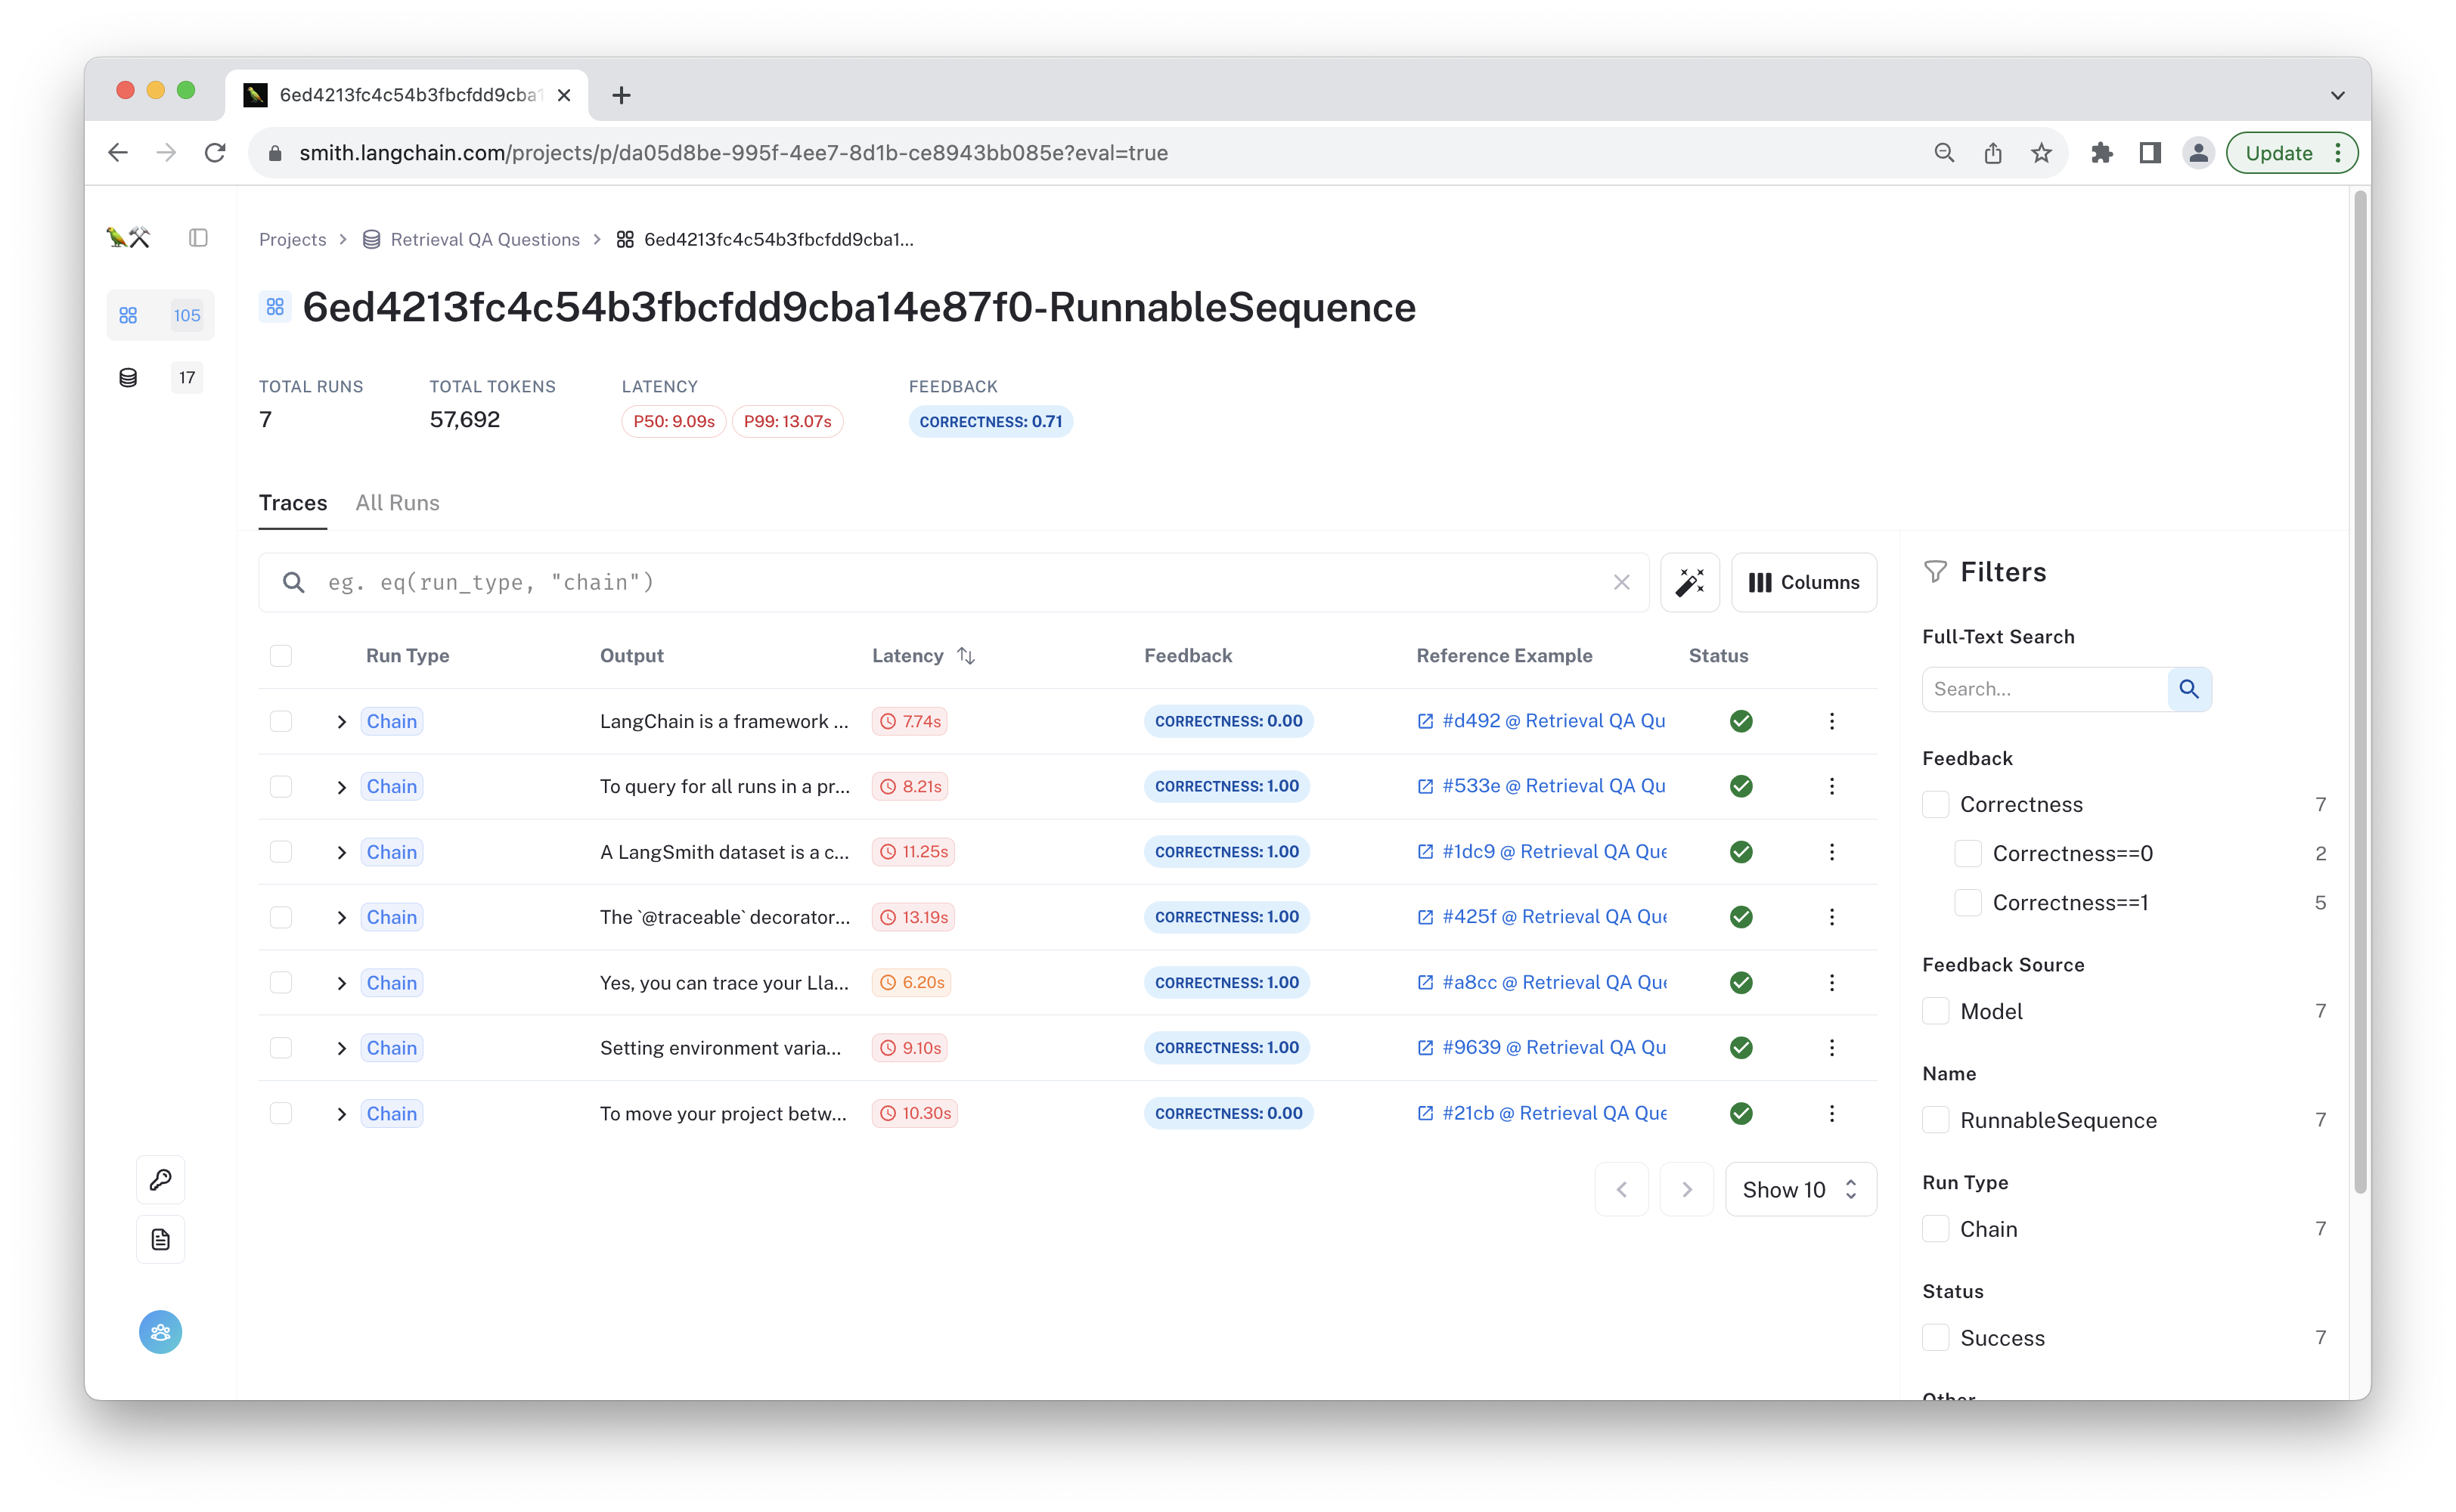

> **Note 1:** This walkthrough tests the end-to-end behavior of the system. Separately evaluating each component of system is still important! Many components, such as the retrievers, can be tested separately using standard retrieval metrics to complement this full integration test.

> **Note 2:** If your knowledge base is changing, make sure your answers are still correct! You can avoid this through some combination of independent testing of chain components, freezing the knowledge source used during testing, and regularly updating your dataset.

Now let's get started!

## Prerequisites

This tutorial uses OpenAI for the model, ChromaDB to store documents, and LangChain to compose the chain. To make sure the tracing and evals are set up for [LangSmith](https://smith.langchain.com), please configure your API Key appropriately.

In [1]:
import os

# Update with your API URL if using a hosted instance of Langsmith.
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "YOUR API KEY"  # Update with your API key
project_name = "YOUR PROJECT NAME"  # Update with your project name

Install the required packages. `lxml` and `html2text` are used by the document loader.

In [2]:
# %pip install -U "langchain[openai]" > /dev/null
# %pip install chromadb > /dev/null
# %pip install lxml > /dev/null
# %pip install html2text > /dev/null

In [3]:
# %env OPENAI_API_KEY=<YOUR-API-KEY>

## 1. Create a Dataset

For our example, we will be evaluating a Q&A system over the LangSmith documentation. In order to measure aggregate accuracy, we'll need to create a list of example question-answer pairs. We've hard-coded some below to demonstrate the process. In general, you'll want a lot more (>100) pairs to get more meaningful results. Drawing from actual queries can be helpful to ensure better representation of the domain.

Below, we have hard-coded some question-answer pairs to evaluate and use the client's `create_example` method to create each example row.

In [4]:
# We have some hard-coded examples here.
examples = [
    (
        "What is LangChain?",
        "LangChain is an open-source framework for building applications using large language models. It is also the name of the company building LangSmith.",
    ),
    (
        "How might I query for all runs in a project?",
        "client.list_runs(project_name='my-project-name'), or in TypeScript, client.ListRuns({projectName: 'my-project-anme'})",
    ),
    (
        "What's a langsmith dataset?",
        "A LangSmith dataset is a collection of examples. Each example contains inputs and optional expected outputs or references for that data point.",
    ),
    (
        "How do I use a traceable decorator?",
        """The traceable decorator is available in the langsmith python SDK. To use, configure your environment with your API key,\
import the required function, decorate your function, and then call the function. Below is an example:
```python
from langsmith.run_helpers import traceable
@traceable(run_type="chain") # or "llm", etc.
def my_function(input_param):
    # Function logic goes here
    return output
result = my_function(input_param)
```""",
    ),
    (
        "Can I trace my Llama V2 llm?",
        "So long as you are using one of LangChain's LLM implementations, all your calls can be traced",
    ),
    (
        "Why do I have to set environment variables?",
        "Environment variables can tell your LangChain application to perform tracing and contain the information necessary to authenticate to LangSmith."
        " While there are other ways to connect, environment variables tend to be the simplest way to configure your application.",
    ),
    (
        "How do I move my project between organizations?",
        "LangSmith doesn't directly support moving projects between organizations.",
    ),
]

In [5]:
from langsmith import Client

client = Client()

In [6]:
import uuid

dataset_name = f"Retrieval QA Questions {str(uuid.uuid4())}"
dataset = client.create_dataset(dataset_name=dataset_name)
for q, a in examples:
    client.create_example(
        inputs={"question": q}, outputs={"answer": a}, dataset_id=dataset.id
    )

## 2. Define RAG Q&A System

Our Q&A system uses a simple retriever and LLM response generator. To break that down further, the chain will be composed of:

1. A [VectorStoreRetriever](https://api.python.langchain.com/en/latest/vectorstores/langchain_core.vectorstores.VectorStoreRetriever.html) to retrieve documents. This uses:
   - An embedding model to vectorize documents and user queries for retrieval. In this case, the [OpenAIEmbeddings](https://api.python.langchain.com/en/latest/embeddings/langchain_openai.embeddings.base.OpenAIEmbeddings.html#langchain_openai.embeddings.base.OpenAIEmbeddingsl) model.
   - A vectorstore, in this case we will use [Chroma](https://api.python.langchain.com/en/latest/vectorstores/langchain_community.vectorstores.chroma.Chroma.html#langchain_community.vectorstores.chroma.Chroma)
2. A response generator. This uses:
   - A [ChatPromptTemplate](https://api.python.langchain.com/en/latest/prompts/langchain_core.prompts.chat.ChatPromptTemplate.html) to combine the query and documents. 
   - An LLM, in this case, the 16k token context window version of `gpt-3.5-turbo` via [ChatOpenAI](https://api.python.langchain.com/en/latest/chat_models/langchain_openai.chat_models.base.ChatOpenAI.html#langchain_openai.chat_models.base.ChatOpenAI).

We will combine them using LangChain's [expression syntax](https://python.langchain.com/docs/expression_language).

First, load the documents to populate the vectorstore:

In [7]:
from langchain_community.document_loaders import RecursiveUrlLoader
from langchain_community.document_transformers import Html2TextTransformer
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import TokenTextSplitter

api_loader = RecursiveUrlLoader("https://docs.smith.langchain.com")
text_splitter = TokenTextSplitter(
    model_name="gpt-3.5-turbo",
    chunk_size=2000,
    chunk_overlap=200,
)
doc_transformer = Html2TextTransformer()
raw_documents = api_loader.load()
transformed = doc_transformer.transform_documents(raw_documents)
documents = text_splitter.split_documents(transformed)

/usr/local/lib/python3.13/site-packages/langchain_community/document_loaders/recursive_url_loader.py:43: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  soup = BeautifulSoup(raw_html, "html.parser")


ImportError: html2text package not found, please 
                install it with `pip install html2text`

With the documents prepared, create the vectorstore retriever. This is what will be used to provide context when generating a response.

In [9]:
embeddings = OpenAIEmbeddings()
vectorstore = Chroma.from_documents(documents, embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 4})

Next up, we'll define the response generator. This responds to the user by injecting the retrieved documents and the user query into a prompt template.

In [10]:
from datetime import datetime

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful documentation Q&A assistant, trained to answer"
            " questions from LangSmith's documentation."
            " LangChain is a framework for building applications using large language models."
            "\nThe current time is {time}.\n\nRelevant documents will be retrieved in the following messages.",
        ),
        ("system", "{context}"),
        ("human", "{question}"),
    ]
).partial(time=str(datetime.now()))

model = ChatOpenAI(model="gpt-3.5-turbo-16k", temperature=0)
response_generator = prompt | model | StrOutputParser()

Finally, assemble the full chain!

In [11]:
# The full chain looks like the following
from operator import itemgetter

chain = (
    # The runnable map here routes the original inputs to a context and a question dictionary to pass to the response generator
    {
        "context": itemgetter("question")
        | retriever
        | (lambda docs: "\n".join([doc.page_content for doc in docs])),
        "question": itemgetter("question"),
    }
    | response_generator
)

In [12]:
for tok in chain.stream({"question": "How do I log user feedback to a run?"}):
    print(tok, end="", flush=True)

To log user feedback to a run in LangSmith, you can use the `create_feedback` method provided by the LangSmith client. Here's an example of how to log user feedback using the Python client:

```python
from langsmith import Client

client = Client()

# Specify the run ID and feedback key
run_id = "<run_id>"
feedback_key = "thumbs_up"

# Log the feedback
client.create_feedback(
    run_id,
    feedback_key,
    score=True
)
```

In this example, we log a "thumbs up" feedback for a specific run by calling `create_feedback` with the run ID, feedback key, and a score of `True`. You can customize the feedback by providing additional optional fields such as `value`, `correction`, `comment`, `source_info`, and `feedback_source_type`.

You can also log feedback using the LangSmith client in TypeScript. Here's an example:

```typescript
import { Client } from "langsmith";

const client = new Client();

// Specify the run ID and feedback key
const runId = "<run_id>";
const feedbackKey = "thumbs_u

## 3. Evaluate the Chain

We will use the off-the-shelf QA evaluator to measure the correctness of the retrieval Q&A responses

In [13]:
from langchain.smith import RunEvalConfig

eval_config = RunEvalConfig(
    evaluators=["qa"],
    # If you want to configure the eval LLM:
    # eval_llm=ChatAnthropic(model="claude-2", temperature=0)
)

Run the evaluation. This makes predictions over the dataset and then uses the "QA" evaluator to check the correctness on each data point.

In [14]:
_ = await client.arun_on_dataset(
    dataset_name=dataset_name,
    llm_or_chain_factory=lambda: chain,
    evaluation=eval_config,
)

View the evaluation results for project 'test-virtual-attitude-2' at:
https://smith.langchain.com/o/9a6371ef-ea6a-4860-b3bd-9614084873e7/projects/p/b539e1db-d7db-4da7-87c3-d9087ed5d0b9
[------------------------------------------------->] 7/7

As the test run progresses, you can navigate to the generated "test run" project to see the chain's outputs, evaluator feedback, and links to the evaluation traces.

From the test project page, you can filter the results based on feedback metrics. For instance, to see the examples marked as incorrect, click on "Correctness==0" in the filters section.

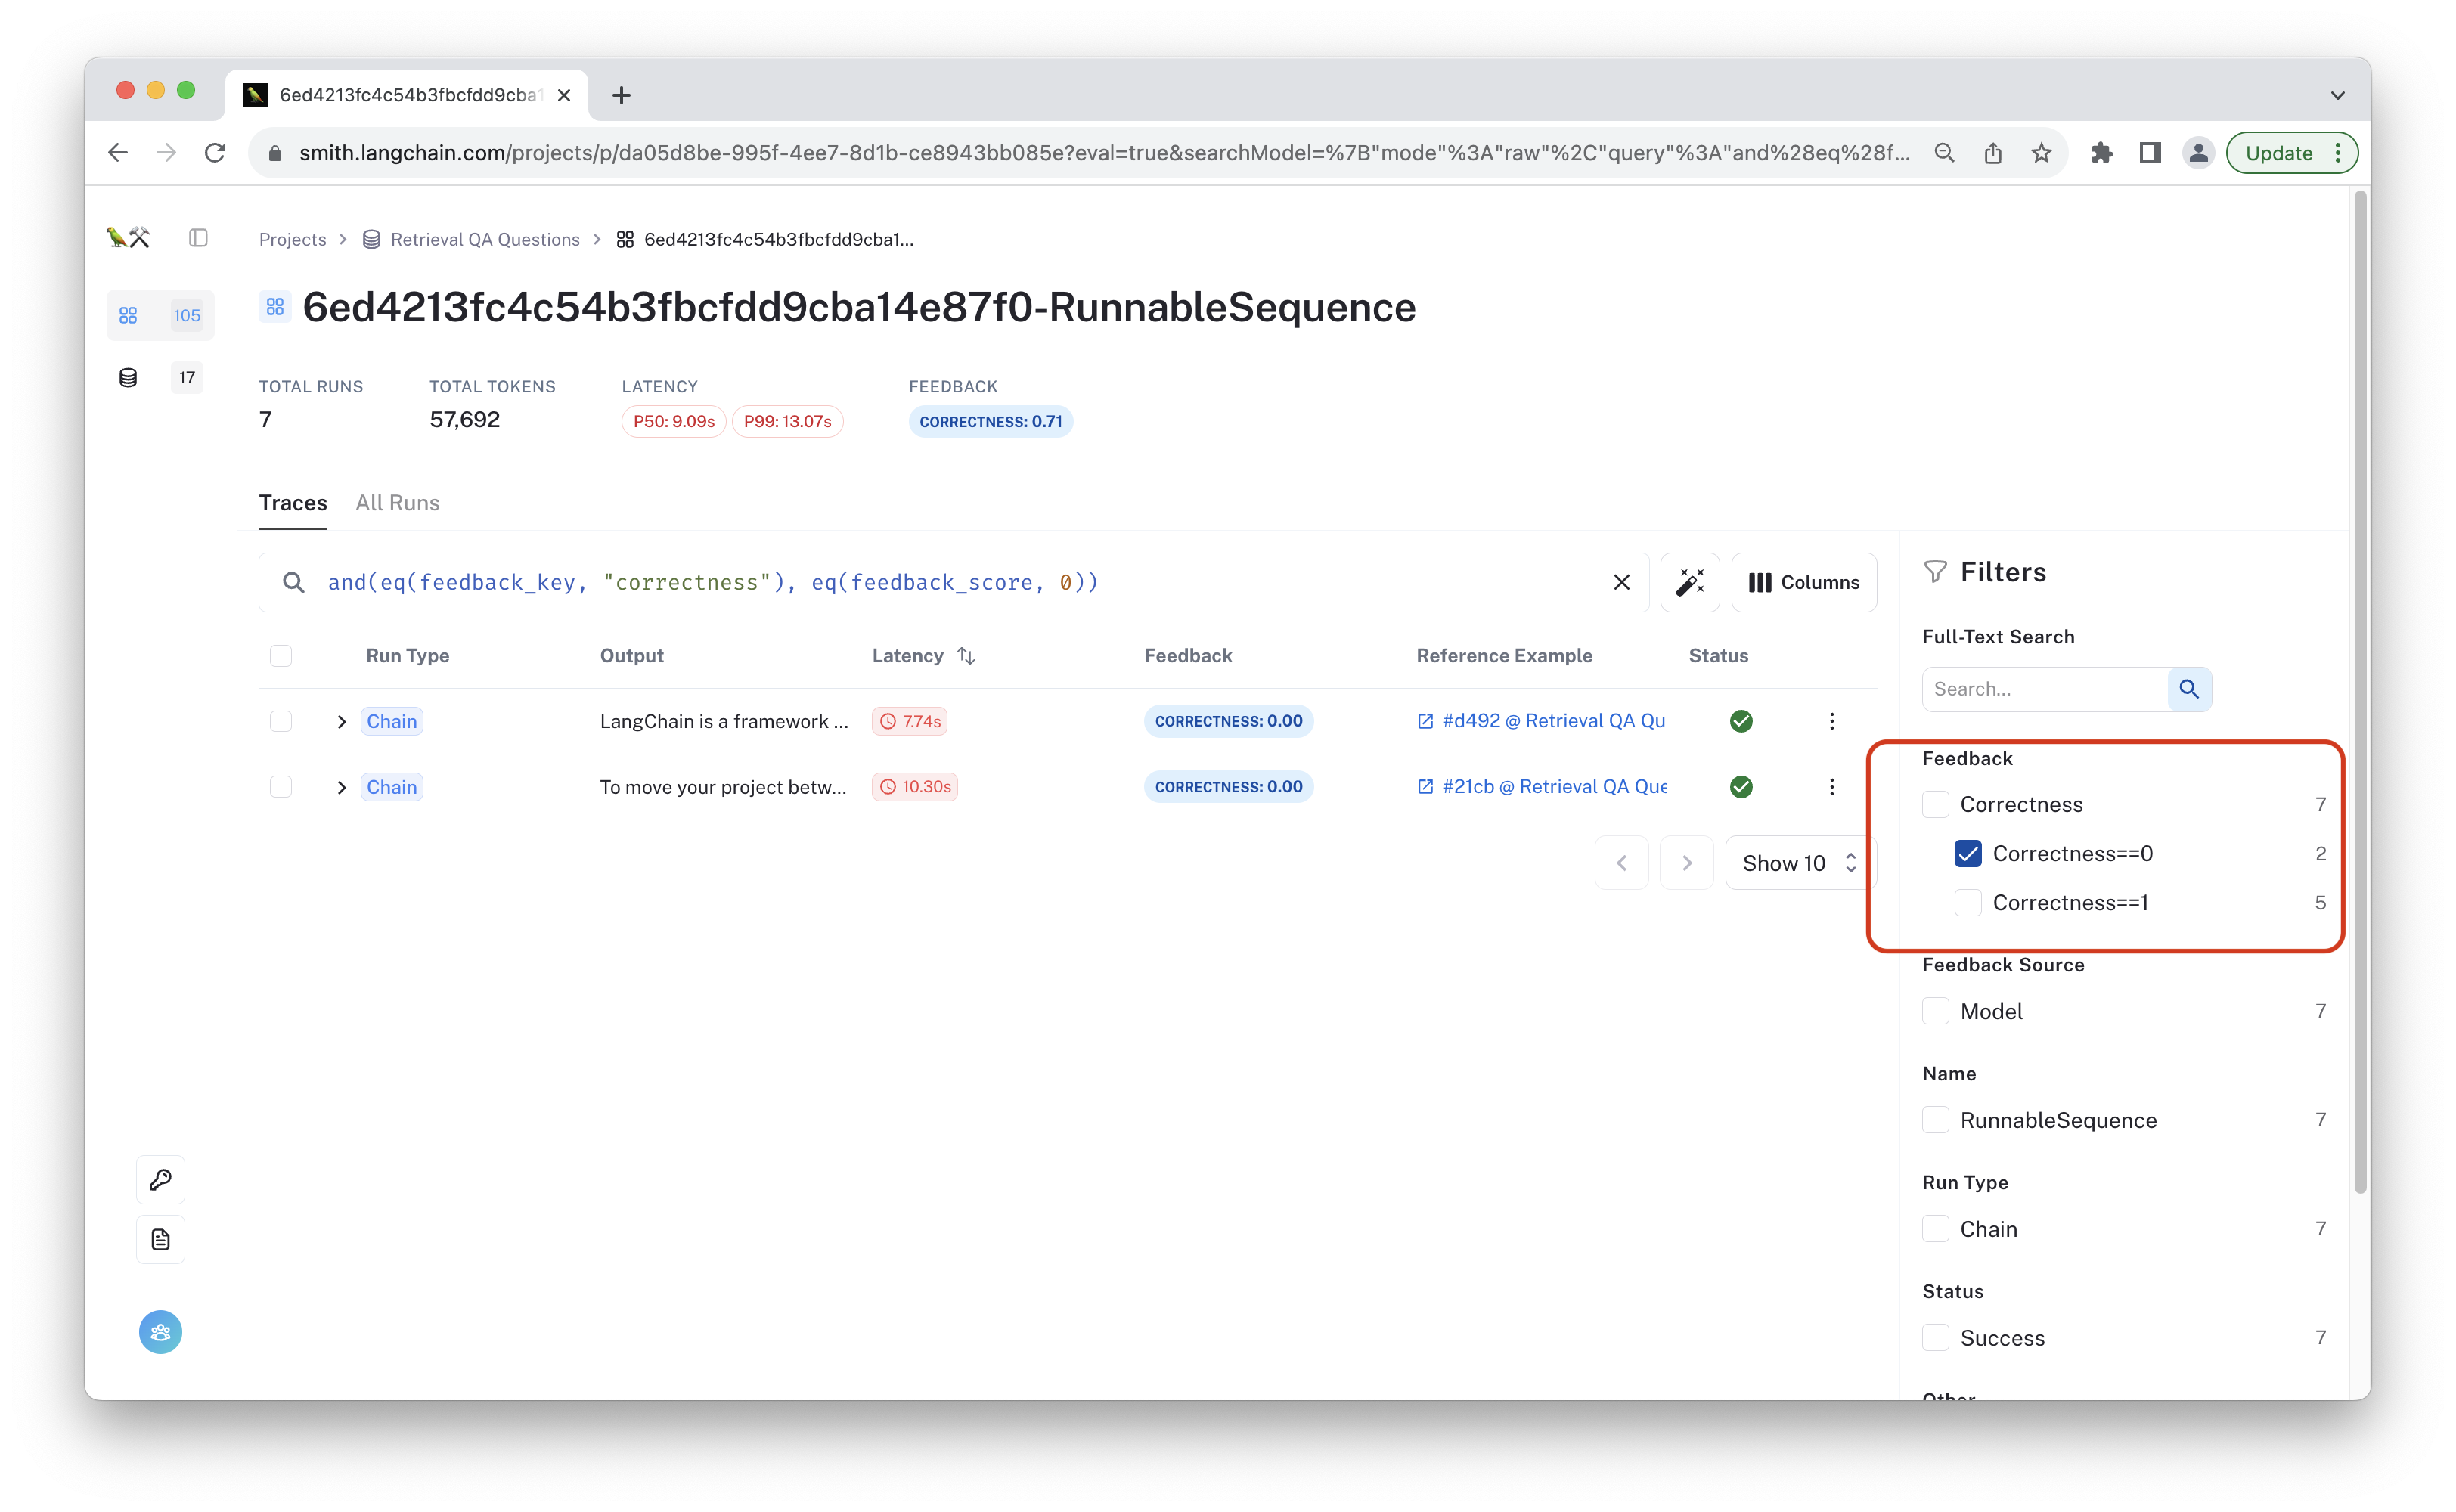

Once you've filtered the results, you can click on the individual runs to see the traces and triage where the chain failed. You can click on the image below to see
for yourself. Navigating to the "Feedback" tab will show the evaluation results linked to this run. 

![Incorrect Example Trace](./img/see_trace.png)

You can click the link highlighted in red above to see the trace of the evaluator run. Since LLM-assisted evaluations are imperfect, viewing their traces is a good way to audit the feedback decisions, and it lets you decide when and how to tailor the prompt to your specific use case.

![QA Eval Chain Run](./img/qa_eval_chain_run.png)


This trace was marked as "incorrect". It looks like the chain is making up information, or "hallucinating." If you click on the `ChatOpenAI` run in your own test project, you can open it in the playground to experiment with changes that may address this error.


![Open in Playground](./img/open_in_playground.png)

Let's try tweaking the prompt to better instruct the model. We'll add an additional system message to remind the model to only respond based on the retrieved documents.
Click "Add Message" and paste in the following text:

> Respond as best as you can. If no documents are retrieved or if you do not see an answer in the retrieved documents, admit you do not know or that you don't see it being supported at the moment.

Click "Submit" to view the results streamed to the message in the right column. If you haven't already added your OpenAI key, you can do so using the "Secrets & API Keys" button.

![Change Prompt](./img/playground_prompt.png)

That seems to have the desired effect for this data point, but we want to be careful that we're not overfitting to a single example. We'll want to re-evaluate to confirm.



## 4. Iterate

The chain did pretty well, and in the previous section we were able to use the playground to come up with a proposed fix to the problem. Let's re-run the evaluation with the new prompt to see how it behaves overall. 
We've copied the chain code below, adding an additional system message to the chat prompt template:

In [15]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful documentation Q&A assistant, trained to answer"
            " questions from LangSmith's documentation."
            "\nThe current time is {time}.\n\nRelevant documents will be retrieved in the following messages.",
        ),
        ("system", "{context}"),
        ("human", "{question}"),
        # Add the new system message here:
        (
            "system",
            "Respond as best as you can. If no documents are retrieved or if you do not see an answer in the retrieved documents,"
            " admit you do not know or that you don't see it being supported at the moment.",
        ),
    ]
).partial(time=lambda: str(datetime.now()))

model = ChatOpenAI(model="gpt-3.5-turbo-16k", temperature=0)
response_generator_2 = prompt | model | StrOutputParser()
chain_2 = {
    "context": itemgetter("question")
    | retriever
    | (lambda docs: "\n".join([doc.page_content for doc in docs])),
    "question": itemgetter("question"),
} | response_generator_2

Rerun the evaluation and check out the results as they become available.

In [16]:
_ = await client.arun_on_dataset(
    dataset_name=dataset_name,
    llm_or_chain_factory=lambda: chain_2,
    evaluation=eval_config,
)

View the evaluation results for project 'test-impressionable-lead-60' at:
https://smith.langchain.com/o/9a6371ef-ea6a-4860-b3bd-9614084873e7/projects/p/fc4f3319-1707-4035-b4e8-b3b3fafcf5b7
[------------------------------------------------->] 7/7

Now we can start comparing results. Navigate to the "Retrieval QA Questions" dataset page to see the aggregate feedback metrics for each test run. You can view your datasets by clicking the datasets & testing icon on the left bar.

![Datasets Page](./img/dataset_test_runs.png)

It looks like the new chain is passing all the examples now. Great job! Remember that this toy dataset, while illustrative, is too small to give a complete picture of the chain's performance. As we continue to prototype this chain, we can add more examples to the dataset.

In addition to the aggregate feedback metrics, you can also view the individual predictions on each row. Click on the "Examples" tab to see each row in the dataset. Clicking on a given example will show the outputs from both test runs for that data point.
Using the linked runs table, you can quickly compare predictions across chain versions to get a quick sense of the types of outputs you might see. You can click on each linked run to view the full traces again.

![Example Page](./img/example.png)

## 5. Conclusion

Congratulations! You've just done a quick evaluation of the correctness of your Q&A system. In this tutorial, you used LangSmith to detect issues in a RAG pipeline and make some prompt tweaks to improve the chain's performance. You have also learned about evaluator feedback and how to use it in your LLM app development process. This is a great start to improving the consistency of your LLM applications.



Thanks for trying this out! If you have questions or suggestions, please open an issue on GitHub or reach out to us at support@langchain.com.